# Análise da malha aérea brasileira em 2019 vs 2020

## Importando Bibliotecas 

https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html?=&t=downloads

In [1]:
!pip install mne

In [ ]:
!pip install geopandas

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm
from mne.viz import plot_connectivity_circle

import seaborn as sns

import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx

In [4]:
!wget https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2020/Brasil/BR/BR_UF_2020.zip
!unzip BR_UF_2020 -d gbr

--2021-08-09 01:30:43--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2020/Brasil/BR/BR_UF_2020.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13793582 (13M) [application/zip]
Saving to: ‘BR_UF_2020.zip.4’

BR_UF_2020.zip.4    100%[===================>]  13.15M  7.97MB/s    in 1.6s    

2021-08-09 01:30:46 (7.97 MB/s) - ‘BR_UF_2020.zip.4’ saved [13793582/13793582]

Archive:  BR_UF_2020.zip
replace gbr/BR_UF_2020.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
br_georef = gpd.read_file("gbr")
br_georef.columns

Index(['CD_UF', 'NM_UF', 'SIGLA_UF', 'NM_REGIAO', 'geometry'], dtype='object')

In [6]:
g19 =nx.read_gml('graph_br_flights_2019.gml.gz')
g20 =nx.read_gml('graph_br_flights_2020.gml.gz')

## Visualizando as linhas aéreas utilizadas em cada ano

In [7]:
def plot_geo_br_flight_data(g, title=""):
  brcolor='#0D0D0D'
  flightcolor='#F0FF6B'
  airportcolor=flightcolor
  bgcolor='#242424'

  fig, ax = plt.subplots( figsize=(8,8) )
  br_georef.plot(ax=ax, kind='geo', color=brcolor, edgecolor='white')

  # Percorrendo cada nó do grafo e adicionando um ponto nas coordenadas
  # do aeroporto
  for node in g.nodes:
    node = g.nodes[node]
    ax.scatter(x=node['LAT'], y=node['LONG'], 
              alpha=0.8, color=airportcolor, s=1 )
  
  # Adicionando uma linha que conecta dois aeroportos ligados por algum voo
  for edge in g.edges:
    node1 = g.nodes[edge[0]]
    node2 = g.nodes[edge[1]]
    ax.plot([node1['LAT'],  node2['LAT'] ], 
            [node1['LONG'], node2['LONG']],
            color=flightcolor, alpha=0.05)
  ax.set_facecolor(bgcolor)
  ax.set_title( title, fontsize=18 )

  fig.show()

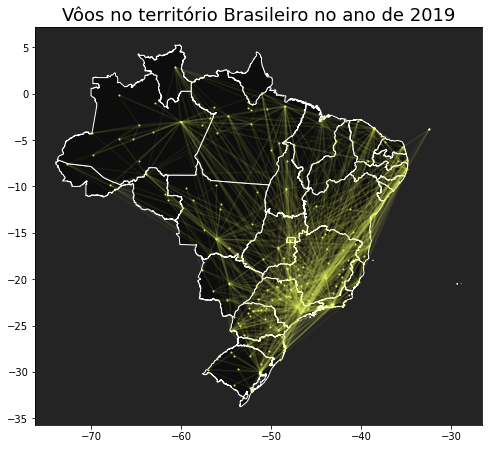

In [8]:
plot_geo_br_flight_data(g19, title="Vôos no território Brasileiro no ano de 2019")

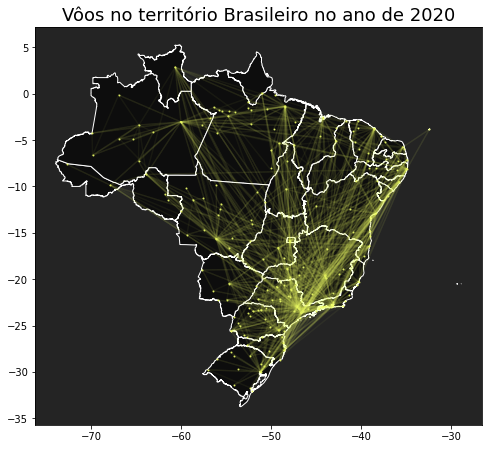

In [9]:
plot_geo_br_flight_data(g20, title="Vôos no território Brasileiro no ano de 2020")

## Visualizando rotas mais movimentadas 

In [10]:
def plot_geo_br_flight_intensity(g, cmap, title=""):
  brcolor='#FFFFFF'
  flightcolor='#F0FF6B'
  airportcolor='black'
  bgcolor='#242424'

  fig, ax = plt.subplots( figsize=(8,8) )
  br_georef.plot(ax=ax, kind='geo', color=brcolor, edgecolor='white')

  # Percorrendo cada nó do grafo e adicionando um ponto nas coordenadas
  # do aeroporto
  for node in g.nodes:
    node = g.nodes[node]
    ax.scatter(x=node['LAT'], y=node['LONG'], 
              alpha=0.8, color=airportcolor, s=1 )
  
  # Adicionando uma linha que conecta dois aeroportos ligados por algum voo
  for edge in g.edges:
    node1 = g.nodes[edge[0]]
    node2 = g.nodes[edge[1]]

    val1 = g[ edge[0] ][ edge[1] ]['VOOS']
    val2 = 0
    if g.has_edge( edge[1], edge[0] ):
      val2 = g[ edge[1] ][ edge[0] ]['VOOS']
    valmax = val1+val2

    ax.plot([node1['LAT'],  node2['LAT'] ], 
            [node1['LONG'], node2['LONG']],
            color=cmap.to_rgba(valmax), alpha=0.2 )
  ax.set_facecolor(bgcolor)
  ax.set_title( title, fontsize=18 )

  fig.colorbar(cmap, ax=ax, label='Número de voos', 
               orientation='vertical',
               shrink=0.4, aspect=20*0.7)

  fig.show()

Encontrando valor máximo de voos

In [11]:
voos_total19 = 0
voos_total20 = 0

for edge in g19.edges:
  voos_total19 = max(voos_total19, g19[edge[0]][edge[1]]['VOOS'])
for edge in g20.edges:
  voos_total20 = max(voos_total20, g20[edge[0]][edge[1]]['VOOS'] )

maxi = max( voos_total19, voos_total20 )

Criando colormap

In [12]:
norm = mpl.colors.PowerNorm(vmin=0, vmax=maxi, gamma=0.6)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

Criando gráfico

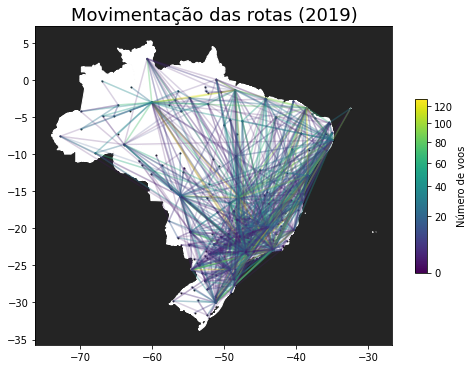

In [13]:
plot_geo_br_flight_intensity(g19, m, title="Movimentação das rotas (2019)")

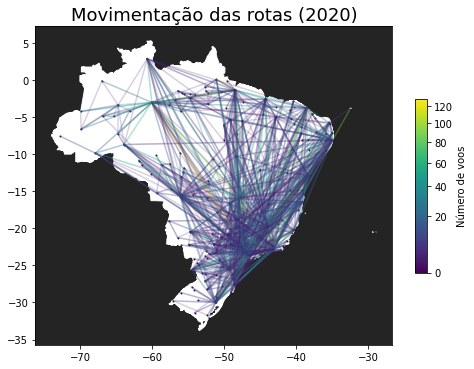

In [14]:
plot_geo_br_flight_intensity(g20, m, title="Movimentação das rotas (2020)")

## Visualizando a Quantidade de voos por estado

In [15]:
def build_df_group_by_UF(g, cols=['VOOS']):
  df = nx.to_pandas_edgelist(g)
  df['source_UF'] = df['source'].apply( lambda x: g.nodes[x]['UF'] )
  df['target_UF'] = df['target'].apply( lambda x: g.nodes[x]['UF'] )

  df_group_source = df[ ['source_UF']+cols ].groupby(by='source_UF').sum()
  df_group_target = df[ ['target_UF']+cols ].groupby(by='target_UF').sum()
  df_result = df_group_source
  df_result[cols] +=  df_group_target[cols]

  df_result = df_result.reset_index()
  df_result = df_result.rename( columns={'source_UF':'UF'} )
  return df_result

Adicionando informações dos voos aos dados georeferenciados

In [16]:
df_flight_uf19 = build_df_group_by_UF(g19, cols=['VOOS'])
df_flight_uf19 = gpd.GeoDataFrame(df_flight_uf19)
df_flight_uf19 = df_flight_uf19.merge( br_georef, left_on='UF', right_on='SIGLA_UF' )

df_flight_uf20 = build_df_group_by_UF(g20, cols=['VOOS'])
df_flight_uf20 = gpd.GeoDataFrame(df_flight_uf20)
df_flight_uf20 = df_flight_uf20.merge( br_georef, left_on='UF', right_on='SIGLA_UF' )

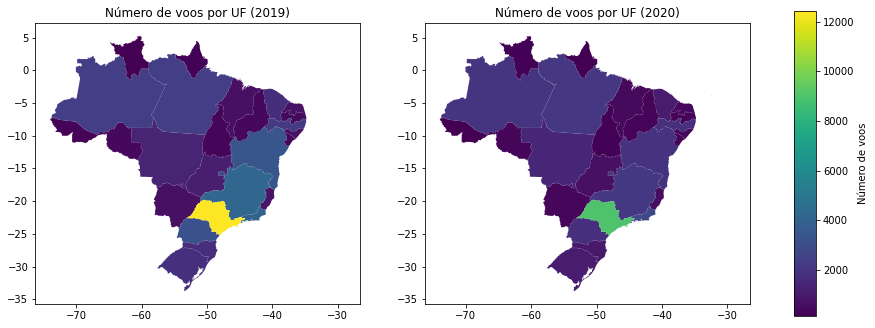

In [17]:
column = 'VOOS'
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

mini = min( df_flight_uf19[column].min(), df_flight_uf20[column].min() )
maxi = max( df_flight_uf19[column].max(), df_flight_uf20[column].max() )

df_flight_uf19.plot(ax=ax[0],
                    column=column, 
                    norm=colors.Normalize(vmin=mini, vmax=maxi) )
df_flight_uf20.plot(ax=ax[1], 
                    column=column, 
                    norm=colors.Normalize(vmin=mini, vmax=maxi) )
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=mini, vmax=maxi), 
                                   cmap=mpl.cm.viridis
                                   ), 
             ax=ax, label='Número de voos', 
             shrink=0.7, aspect=20*0.7 )

ax[0].set_title("Número de voos por UF (2019)")
ax[1].set_title("Número de voos por UF (2020)")
fig.show()

## Calculando quantidade de voos entre regiões

In [18]:
def build_nodes_df(g, atributes = ['UF']):
  df = pd.DataFrame( columns=['node']+atributes )
  df['node'] = list(g.nodes)
  df.set_index('node', inplace=True)

  for node in list(g.nodes):
    for col in atributes:
      df[ col ][ node ] = g.nodes[ node ][col]
  return df

In [19]:
def build_flight_categorical_co_ocurrence( g, df, atrr='REGIAO', score='VOOS' ):
  df[ df.columns ] = 0
  for edge in g.edges:
    node1, node2 = edge
    df[ g.nodes[node1][atrr] ][ g.nodes[node2][atrr] ] += g[node1][node2][score]
    df[ g.nodes[node2][atrr] ][ g.nodes[node1][atrr] ] += g[node1][node2][score]

  return df

Construindo atributos do nos

In [20]:
df_nodes20 = build_nodes_df(g20, atributes=['REGIAO'])
df_nodes19 = build_nodes_df(g19, atributes=['REGIAO'])

Construindo matriz de co-ocorrencias baseado na região

In [21]:
regions = ['NORTE', 'NORDESTE', 'SUDESTE', 'CENTRO-OESTE', 'SUL']
df_regions19 = pd.DataFrame( columns=regions, index=regions ).fillna(0)
df_regions20 = pd.DataFrame( columns=regions, index=regions ).fillna(0)

Construindo as matrizes e zerando as diagonais

In [22]:
adj_regions19 = build_flight_categorical_co_ocurrence( g19, df_regions19 ).to_numpy()
adj_regions20 = build_flight_categorical_co_ocurrence( g20, df_regions20 ).to_numpy()

for i in range(len(regions)):
  adj_regions19[ i ][ i ] = 0
  adj_regions20[ i ][ i ] = 0

mini = min( adj_regions19.min(), adj_regions20.min() )
maxi = max( adj_regions19.max(), adj_regions20.max() )

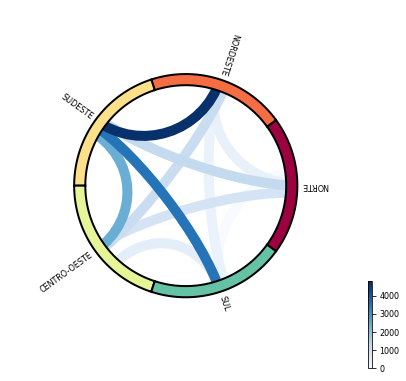

2019


In [23]:
plot_connectivity_circle(adj_regions19, regions, vmin=mini, vmax=maxi,
                          colormap='Blues', facecolor='white', 
                          textcolor='black', colorbar=True, linewidth=10)
print("2019")

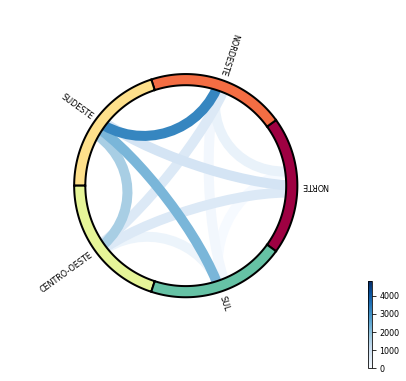

2020


In [24]:
plot_connectivity_circle(adj_regions20, regions, vmin=mini, vmax=maxi, 
                         colormap='Blues', facecolor='white', 
                         textcolor='black', colorbar=True, linewidth=10)
print("2020")

## Visualizando os voos por tipo

In [25]:
df19 = nx.to_pandas_edgelist(g19)[ ['VOO_NAO_REGULAR', 'VOO_REGULAR', 'IMPRODUTIVO'] ]
df20 = nx.to_pandas_edgelist(g20)[ ['VOO_NAO_REGULAR', 'VOO_REGULAR', 'IMPRODUTIVO'] ]

In [26]:
df_flight_type = pd.DataFrame(df19.sum()).reset_index()
df_flight_type['year'] = 2019
_ = pd.DataFrame(df20.sum()).reset_index()
_['year'] = 2020
df_flight_type = pd.concat( [df_flight_type, _] )
df_flight_type = df_flight_type.rename( columns={ 'index':'Tipo de voo', 0:'Quantidade' } )

Text(0.5, 0.98, 'Contagem de voos')

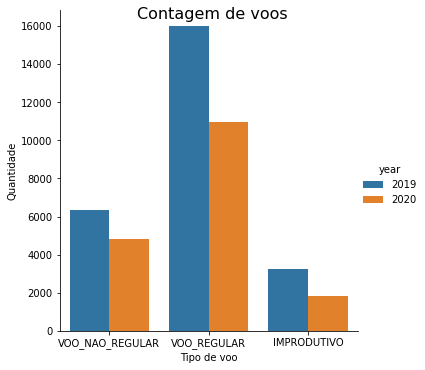

In [27]:
g = sns.catplot(data=df_flight_type, hue='year',
                kind="bar", x='Tipo de voo', y='Quantidade' )
g.fig.suptitle('Contagem de voos', fontsize=16)

# Comparação de distribuições


## PDF da distância voada 

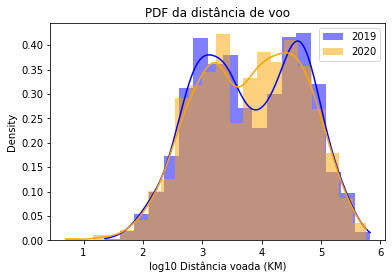

In [28]:
fig, ax = plt.subplots( ncols=1 )

df19 = nx.to_pandas_edgelist(g19).query("DISTANCIA_VOADA_KM > 0")["DISTANCIA_VOADA_KM"]
df20 = nx.to_pandas_edgelist(g20).query("DISTANCIA_VOADA_KM > 0")["DISTANCIA_VOADA_KM"]
df19 = np.log10(df19)
df20 = np.log10(df20)

sns.histplot(df19, label="2019", kde=True, 
             color='blue', stat='density', 
             linewidth=0, ax=ax)
sns.histplot(df20, label="2020", kde=True,
             color='orange', stat='density', 
             linewidth=0, ax=ax)

ax.set_xlabel( "log10 Distância voada (KM)" )
ax.set_title(  "PDF da distância de voo" )
plt.legend()
plt.show()

# Métricas de centralidade

## Engenvector Centrality

In [29]:
def plot_geo_br_nodes(g, node_scores, ax=None, cmap='YlOrRd', title=""):
  brcolor='#FFFFFF'
  flightcolor='#000000'
  airportcolor=flightcolor
  bgcolor='#242424'

  if ax == None:
    fig, ax = plt.subplots( figsize=(8,8) )

  br_georef.plot(ax=ax, kind='geo', color=brcolor, edgecolor='white')
  
  # Construindo dataset com informação de todos os nós da rede
  df = pd.DataFrame(g.nodes, columns=['CODIGO'])
  df = df.set_index( ['CODIGO'] )
  df['SCORE'] = pd.Series(node_scores)
  df['LAT'] = pd.Series(g.nodes).apply( lambda x: x['LAT'] )
  df['LONG'] = pd.Series(g.nodes).apply( lambda x: x['LONG'] )

  ax.scatter(x=df['LAT'], y=df['LONG'], s=25, alpha=0.8,
             c=df['SCORE'], cmap=cmap )
  
  ax.set_facecolor(bgcolor)
  ax.set_title( title, fontsize=18 )

  plt.show()
  return ax

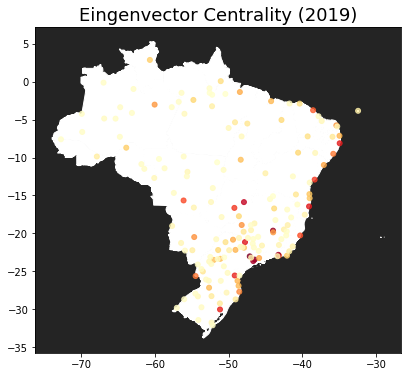

In [30]:
fig, ax = plt.subplots( figsize=(12,6) )
node_scores19 = nx.eigenvector_centrality(g19)
plot_geo_br_nodes(g19, node_scores19, ax=ax, 
                  title="Eingenvector Centrality (2019)")

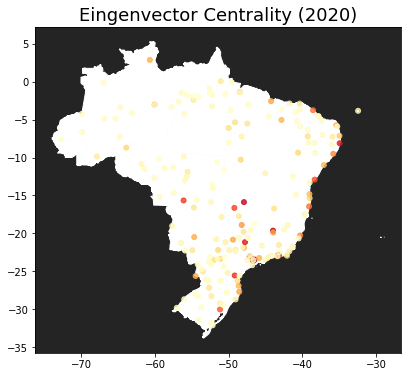

In [31]:
fig, ax = plt.subplots( figsize=(12,6) )
node_scores20 = nx.eigenvector_centrality(g20)
plot_geo_br_nodes(g20, node_scores20, ax=ax, 
                  title="Eingenvector Centrality (2020)")

## Correlação entre Closeness, Betweness, Eigenvector

In [32]:
def transform_dict_scores_to_df( scores, score_name ):
  index = list(scores.keys())
  df = pd.DataFrame(columns=['node', score_name])
  df['node'] = index
  df = df.set_index('node')

  for node in index:
    df[score_name][node] = scores[node]

  return df

In [33]:
eigen19 = nx.eigenvector_centrality(g19)
eigen20 = nx.eigenvector_centrality(g20)

betwen19 = nx.betweenness_centrality(g19)
betwen20 = nx.betweenness_centrality(g20)

close19 = nx.closeness_centrality(g19)
close20 = nx.closeness_centrality(g20)

In [34]:
df19 = transform_dict_scores_to_df(eigen19, 'eigenvector' )
df19 = df19.merge( transform_dict_scores_to_df(close19, 'closeness'), on='node' )
df19 = df19.merge( transform_dict_scores_to_df(betwen19, 'betweness'), on='node' )
df19['ANO'] = '2019'

df20 = transform_dict_scores_to_df(eigen19, 'eigenvector')
df20 = df20.merge( transform_dict_scores_to_df(close20, 'closeness'), on='node' )
df20 = df20.merge( transform_dict_scores_to_df(betwen20, 'betweness'), on='node' )
df20['ANO'] = '2020'

df_final = pd.concat( [df19, df20], axis=0 )
df_final = df_final.fillna(0)

In [35]:
df_final

,eigenvector,closeness,betweness,ANO
node,,,,
SBAE,0.091990,0.439694,0.000846,2019
SBCA,0.041038,0.415205,0.000128,2019
SBCF,0.241316,0.600755,0.110397,2019
SBCG,0.122538,0.472640,0.011937,2019
SBDN,0.063514,0.454310,0.001224,2019
...,...,...,...,...
SSVL,0.006782,0.354296,0.010581,2020
SSCP,0.000250,0.261611,0.000000,2020
SJHG,0.000227,0.206902,0.002612,2020


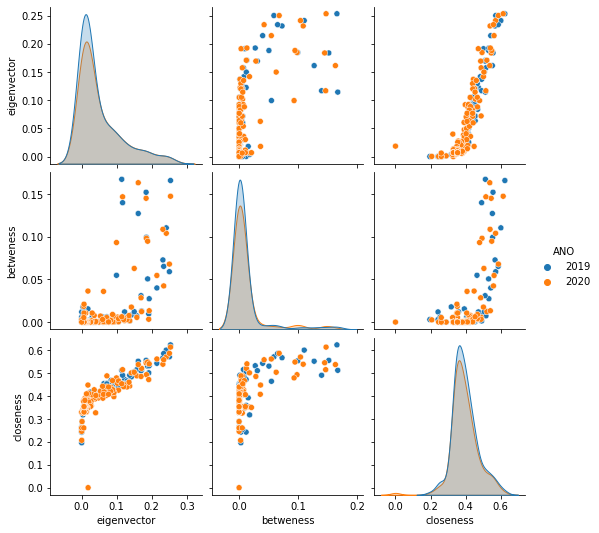

In [36]:
ax = sns.pairplot(df_final,
             x_vars=['eigenvector', 'betweness', 'closeness'], 
             y_vars=['eigenvector', 'betweness', 'closeness'],
             hue='ANO', diag_kind="kde")

## Distribuição dos K-Cores

In [38]:
## Transformando o DiGraph em Graph
g19_un = g19.to_undirected()
g20_un = g20.to_undirected()

In [39]:
g19_un.remove_edges_from(nx.selfloop_edges(g19_un))
g20_un.remove_edges_from(nx.selfloop_edges(g20_un))

Text(0.5, 0.98, 'Contagem de K-cores em cada ano')

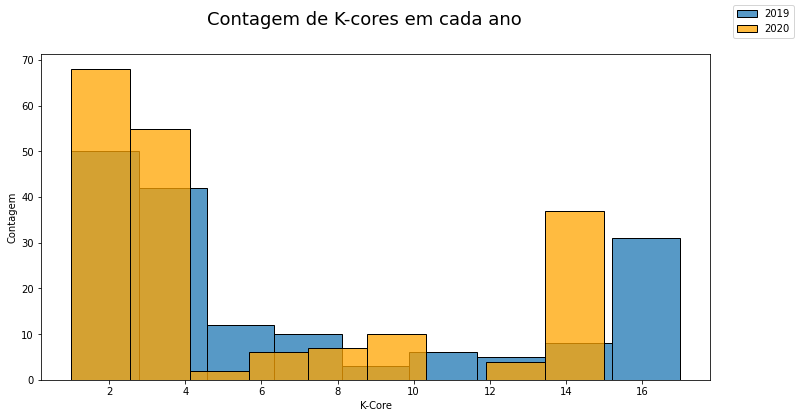

In [40]:
fig, ax = plt.subplots( ncols=1, figsize=(12,6) )
sns.histplot(nx.core_number(g19_un), ax=ax, label = "2019")
sns.histplot(nx.core_number(g20_un), ax=ax, label = "2020", color='orange')
ax.set_xlabel("K-Core")
ax.set_ylabel("Contagem")
fig.legend()
fig.suptitle("Contagem de K-cores em cada ano", fontsize=18)

## K-Cores no mapa

Visualizando os K-Cores da rede

In [41]:
def plot_geo_br_node_intensity(g, scores, cmap, title=""):
  brcolor='#FFFFFF'
  flightcolor='#F0FF6B'
  airportcolor='black'
  bgcolor='#242424'

  fig, ax = plt.subplots( figsize=(8,8) )
  br_georef.plot(ax=ax, kind='geo', color=brcolor, edgecolor='white')

  # Percorrendo cada nó do grafo e adicionando um ponto nas coordenadas
  # do aeroporto
  for node in g.nodes:
    score = scores[node]
    node = g.nodes[node]
    ax.scatter(x=node['LAT'], y=node['LONG'], 
               alpha=0.8, color=cmap.to_rgba(score), s=25 )

  fig.colorbar(cmap, ax=ax, label='Número de voos', 
               orientation='vertical',
               shrink=0.4, aspect=20*0.7)
  ax.set_facecolor(bgcolor)
  ax.set_title( title, fontsize=18 )
  
  fig.show()

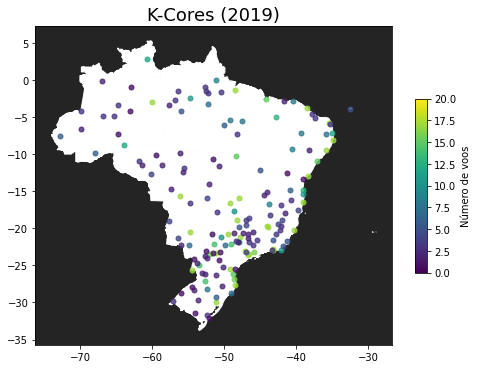

In [42]:
norm = mpl.colors.Normalize(vmin=0, vmax=20)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plot_geo_br_node_intensity(g19, nx.core_number(g19_un), m, title="K-Cores (2019)")

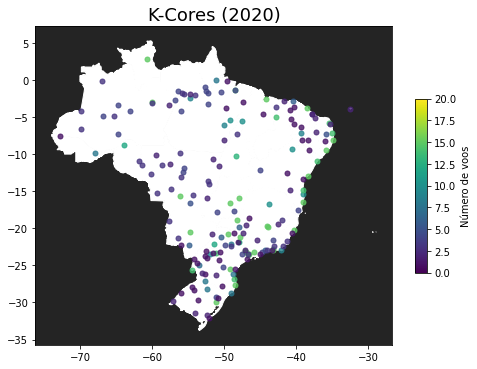

In [43]:
plot_geo_br_node_intensity(g20, nx.core_number(g20_un), m, title="K-Cores (2020)")

## Estados com maior K-Core médio

Vamos reutilizar o dataframe utilizado para plotagem de gráficos de voos por esstado

In [44]:
estados = df_flight_uf19['UF'].unique()

In [45]:
kcore19 = transform_dict_scores_to_df( nx.core_number(g19_un), score_name='kcore' )
kcore19['kcore'] = kcore19['kcore'].astype(int)
kcore19 = kcore19.reset_index()
kcore19['UF'] = kcore19['node'].apply( lambda x: g19.nodes[x]['UF'] )

kcore20 = transform_dict_scores_to_df( nx.core_number(g20_un), score_name='kcore' )
kcore20['kcore'] = kcore20['kcore'].astype(int)
kcore20 = kcore20.reset_index()
kcore20['UF'] = kcore20['node'].apply( lambda x: g20.nodes[x]['UF'] )

In [46]:
kcore19_uf = kcore19[['UF', 'kcore']].groupby(by='UF').mean()
kcore19_uf = kcore19_uf.reset_index()

kcore20_uf = kcore19[['UF', 'kcore']].groupby(by='UF').mean()
kcore20_uf = kcore20_uf.reset_index()

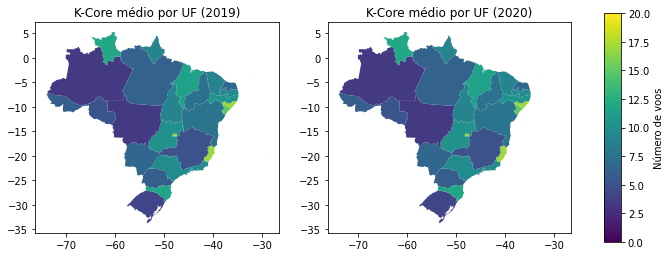

In [47]:
column='kcore'
mini = 0
maxi = 20

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
kcore19_uf = gpd.GeoDataFrame(kcore19_uf)
kcore19_uf = kcore19_uf.merge( br_georef, left_on='UF', right_on='SIGLA_UF' )

kcore20_uf = gpd.GeoDataFrame(kcore20_uf)
kcore20_uf = kcore20_uf.merge( br_georef, left_on='UF', right_on='SIGLA_UF' )

kcore19_uf.plot(ax=ax[0],
                    column=column, 
                    norm=colors.Normalize(vmin=mini, vmax=maxi) )
kcore20_uf.plot(ax=ax[1], 
                column=column, 
                norm=colors.Normalize(vmin=mini, vmax=maxi) )

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=mini, vmax=maxi), 
                                   cmap=mpl.cm.viridis
                                   ), 
             ax=ax, label='Número de voos', 
             shrink=0.7, aspect=20*0.7 )

ax[0].set_title("K-Core médio por UF (2019)")
ax[1].set_title("K-Core médio por UF (2020)")
fig.show()